### Introducción
>
>En esta unidad aprenderemos sobre la regresión en su variante más general: la regresión lineal. Emplearemos una base de datos sobre ingresos de una empresa y buscaremos los determinantes asociados a mayores ingresos.
>
>La regresión responde a la pregunta ¿Cómo el cambio de una variable afecta el valor de otra variable? Y podemos definirla como un método muy flexible relacionado con las preguntas de asociación y causalidad de nuestros fenómenos por estudiar.
>
>En esta unidad trabajaremos con el caso más simple: la regresión lineal. Por lineal hablamos del caso donde nuestra variable objetivo (o dependiente) es continua y la relación entre esta y los atributos (o variables independientes) es mediante una combinación lineal de los últimos.
>
>Te invitamos a introducirte en este contenido, el cual sin duda aportará en tu formación como analista a futuro.
>
### Codificación de Variables Categóricas
>
>Antes de comenzar a hablar del modelo de regresión lineal que trataremos en este capítulo, debemos poner atención a un desafío bastante interesante que necesitaremos resolver para poder mostrarle toda la información que requerimos usar a nuestro modelo.
>
>El problema es el siguiente:
>
>Un modelo de regresión lineal (y en su defecto, todos aquellos modelos que vayamos a estudiar en la carrera) es un modelo estadístico, eso quiere decir que la forma en la que toma sus decisiones tienen origen en los fundamentos matemáticos usados para definir el modelo. Esto implica que este requiere de representaciones numéricas de la información para poder aprender del fenómeno. En el caso de las variables intrínsecamente numéricas, esto no es problema porque ya existen el conjunto de los reales/naturales, sin embargo, ¿qué ocurre con las variables categóricas?. Estas variables existen en un dominio discreto que no necesariamente es un subconjunto de los reales; por ejemplo, las etiquetas de texto, como el continente al que pertenece un país, no tiene una traducción natural a un número en algún espacio predefinido. Para solucionar esto, tendremos que codificar aquellas variables categóricas a una representación numérica. Y aunque no lo parezca, en desafíos pasados hemos realizado algunas de las codificaciones que ahora veremos más formalmente, por lo que algunas nos debieran
parecer familiares: 
>
>Para ejemplificar estas transformaciones consideraremos el mismo ejemplo en todos los casos, recordando el dataset nations:


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import lec5_graphs as gfx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [2]:
df_prob = pd.read_csv('datasets/nations.csv', encoding='latin-1', index_col=[0])
df_prob.head()

,country,region,gdp,school,adfert,chldmort,life,pop,urban,femlab,literacy,co2,gini
1,Algeria,Africa,7300.399902,6.716667,7.300000,34.75,72.316666,34172236,64.933334,0.4522,72.599998,15.0,NaN
2,Benin,Africa,1338.800049,3.100000,111.699997,122.75,54.733334,8237634,41.000000,0.8482,41.700001,1.2,NaN
3,Botswana,Africa,12307.400391,8.600000,52.099998,60.25,52.250000,1941233,59.250000,0.8870,84.099998,9.2,NaN
4,Burkina Faso,Africa,1063.400024,1.300000,124.800003,170.50,53.783333,15308383,23.583334,0.8584,23.600000,0.2,NaN
5,Burundi,Africa,349.200012,2.483333,18.600000,168.50,48.866665,7821783,10.250000,1.0344,66.599998,0.1,33.299999


>Propongámonos el ejercicio de transformar la variable/columna región (continentes) a
>
>una representación numérica:
>
>1. One-Hot Encoding (OHE) 
>
>Sea una variable categórica con K clases distintas, OHE indica que debemos generar K columnas nuevas, donde cada columna nueva representará, para cada fila, la ocurrencia de una determinada clase. En el ejemplo de la columna region de nations, la representación OHE puede ser obtenida fácilmente utilizando la función pd.get_dummies() de pandas:


In [3]:
pd.get_dummies(df_prob['region'])

,Africa,Americas,Asia,Europe,Oceania
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
190,0,0,0,0,1
191,0,0,0,0,1
192,0,0,0,0,1
193,0,0,0,0,1


>De forma un poco más técnica, lo que OHE realiza es generar vectores perpendiculares entre sí y con norma unitaria, y estos viven en un espacio de dimensionalidad K.
>
>2. Binary Encoding
>
>Binary Encoding es bastante similar a OHE, con la única diferencia que Binary Encoding codifica una variable categórica con K clases en K-1 columnas. En pandas, esto se puede hacer también con la función pd.get_dummies() con el argumento drop_first = True:

In [4]:
pd.get_dummies(df_prob.region, drop_first = True)

,Americas,Asia,Europe,Oceania
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
...,...,...,...,...
190,0,0,0,1
191,0,0,0,1
192,0,0,0,1
193,0,0,0,1


>Algo que probablemente sea común pensar a partir de este ejercicio es ¿Por qué existe tanto Binary Encoding como OHE si son casi lo mismo y logran representar la misma información?
>
>La razón de esto es que aunque OHE lográ representar las clases de forma bastante explícita, su representación tiene la particularidad de generar columnas colineales entre sí. Para hacer más fácil mostrar esto, consideremos el caso de codificar una columna de sexo de personas que contiene los valores [Hombre, Mujer]. En este caso, OHE generaría dos
columnas (una para cada clase), quedando las clases representadas por los vectores (1, 0) y (0, 1). Si ponemos atención a los vectores que representan las clases, notaremos que es posible predecir el valor que va a tomar el segundo elemento del vector solamente observando el valor que tomó el primer elemento de este. Más específicamente, eso quiere decir que la relación entre las dos columnas creadas es la siguiente:
>
>𝐻 = 1 − M
>
>¡Esto es una recta! (de ahí el nombre de colinealidad) H es una combinación lineal de M y eso implica que la matriz de codificaciones entregada por OHE no es fullrank. Al no ser fullrank, la inversa de la matriz de datos no está definida, y el problema que esto genera es que el estimador OLS de una regresión lineal (que presentaremos más adelante) no pueda ser calculado de forma analítica ya que se requiere el cálculo de la inversa de la matriz 𝑋 , la cua,l al igual que para nuestra matriz 𝑇𝑋 de datos 𝑋, no tiene inversa definida en el caso no fullrank de 𝑋. 
>
>Binary Encoding elimina esta colinealidad omitiendo la presencia explícita de una clase, la cual, como puede ser deducido, queda codificada en el origen del sistema de vectores que se genera. Mientras OHE nunca ocupa el origen de este sistema (0, 0, 0, ...) en binary encoding la clase omitida ocupa esta posición y eso se puede ver en el output de mostrado anteriormente, donde la clase de Africa queda codificada en el vector (0, 0, 0, 0).
>
>Nota: Una matriz fullrank es aquella cuyas columnas y/o filas son linealmente independientes.
>
>3. Label Encoding
>
>Para una columna categórica con K clases, Label Encoding genera una sola columna con las clases codificadas con números naturales . Por ejemplo, África estaría asignado al número 1, Asia al número 2, Europa al 3. etc. Aunque esto parece ser una mejor forma de codificar las categorías, debemos tener en cuenta que esto también impone un orden en las clases que puede no existir en los datos originales, ¿Por qué un continente debe tener un valor más alto que otro?. Label Encoding debe ser usado para codificar variables categóricas ordinales (como los puestos en los que salen los medallistas olímpicos o los días de la semana/meses del año), no para variables nominales como los continentes, por lo que, en este último caso, preferimos Binary Encoding u OHE.
Por ahora no necesitaremos Label Encoding por lo que lo introduciremos en el siguiente módulo cuando veamos la librería scikit-learn donde se implementan todas estas transformaciones.
>
>Finalmente, mencionar que una vez que hemos codificado una o más variables categóricas, estas representaciones reemplazan a las variables originales en la matriz que debemos ingresar a nuestro modelo. Por otro lado, para adicionar estas representaciones a un DataFrame en pandas basta utilizar la función pd.concat:



In [5]:
region_coded = pd.get_dummies(df_prob.region, drop_first = True)
pd.concat([df_prob, region_coded], axis = 1)

,country,region,gdp,school,adfert,chldmort,life,pop,urban,femlab,literacy,co2,gini,Americas,Asia,Europe,Oceania
1,Algeria,Africa,7300.399902,6.716667,7.300000,34.75,72.316666,34172236,64.933334,0.4522,72.599998,15.00,NaN,0,0,0,0
2,Benin,Africa,1338.800049,3.100000,111.699997,122.75,54.733334,8237634,41.000000,0.8482,41.700001,1.20,NaN,0,0,0,0
3,Botswana,Africa,12307.400391,8.600000,52.099998,60.25,52.250000,1941233,59.250000,0.8870,84.099998,9.20,NaN,0,0,0,0
4,Burkina Faso,Africa,1063.400024,1.300000,124.800003,170.50,53.783333,15308383,23.583334,0.8584,23.600000,0.20,NaN,0,0,0,0
5,Burundi,Africa,349.200012,2.483333,18.600000,168.50,48.866665,7821783,10.250000,1.0344,66.599998,0.10,33.299999,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Samoa,Oceania,4012.600098,10.300000,28.299999,26.75,71.533333,181600,20.666668,0.5010,98.800003,3.10,NaN,0,0,0,1
191,Solomon Islands,Oceania,2249.199951,4.500000,70.300003,36.00,66.500000,503617,17.766666,0.4858,NaN,1.40,NaN,0,0,0,1
192,Tonga,Oceania,4072.199951,10.133333,22.299999,19.25,71.833336,102550,23.266666,0.7150,99.000000,4.85,NaN,0,0,0,1
193,Tuvalu,Oceania,NaN,NaN,23.299999,36.50,66.033333,9767,49.233334,NaN,NaN,NaN,NaN,0,0,0,1


### Nuestro primer modelo de regresión
>
>En esta ocasión, trabajaremos con una base de datos sobre los ingresos de una muestra, en base a una serie de atributos.


In [6]:
df = pd.read_csv('datasets/earnings.csv')
df.head()

,Unnamed: 0,earn,height1,height2,sex,race,hisp,ed,yearbn,height,age,age_category,eth,male
0,3,50000.0,6,2,1,1,2,16,45,74,45,2,3,1
1,4,60000.0,5,6,2,1,2,16,32,66,58,3,3,0
2,5,30000.0,5,4,2,1,2,16,61,64,29,1,3,0
3,9,51000.0,5,3,2,1,2,17,51,63,39,2,3,0
4,10,9000.0,5,4,2,1,2,15,64,64,26,1,3,0


In [7]:
df.describe()

,Unnamed: 0,earn,height1,height2,sex,race,hisp,ed,yearbn,height,age,age_category,eth,male
count,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000
mean,1029.446143,19981.433770,5.128821,5.050218,1.622999,1.167394,1.941776,13.353712,48.848617,66.596070,41.151383,1.861718,2.780204,0.377001
std,587.765286,19781.488482,0.360261,3.173719,0.484812,0.641772,0.234252,2.440269,15.542169,3.803324,15.542169,0.814886,0.628077,0.484812
min,3.000000,0.000000,4.000000,0.000000,1.000000,1.000000,1.000000,3.000000,3.000000,58.000000,18.000000,1.000000,1.000000,0.000000
25%,520.250000,6000.000000,5.000000,3.000000,1.000000,1.000000,2.000000,12.000000,39.000000,64.000000,29.000000,1.000000,3.000000,0.000000
50%,1027.500000,16000.000000,5.000000,5.000000,2.000000,1.000000,2.000000,13.000000,52.000000,66.000000,38.000000,2.000000,3.000000,0.000000
75%,1536.750000,28000.000000,5.000000,8.000000,2.000000,1.000000,2.000000,15.000000,61.000000,69.000000,51.000000,3.000000,3.000000,1.000000
max,2029.000000,200000.000000,6.000000,11.000000,2.000000,9.000000,2.000000,18.000000,72.000000,77.000000,87.000000,3.000000,4.000000,1.000000


>describe() es útil, pero para las variables categóricas es mejor ver sus frecuencias. Para ello, utilizaremos .value_counts() en cada variable.

In [8]:
# separemos todas las variables que son categóricas
categorical_columns = ['sex', 'race', 'hisp', 'age_category', 'eth', 'male']

In [9]:
# iniciamos un loop para cada variable categórica donde:
for cat in categorical_columns:
# imprimimos el nombre
    print("\n",cat)
# solicitamos la frecuencia relativa de cada categoría dentro de la variable
    print(df[cat].value_counts())
# solicitamos el porcentaje de la frecuencia relativa
print((df[cat].value_counts()/len(df[cat])))



 sex
2    856
1    518
Name: sex, dtype: int64

 race
1    1216
2     126
3      17
4      10
9       5
Name: race, dtype: int64

 hisp
2    1294
1      80
Name: hisp, dtype: int64

 age_category
1    564
2    436
3    374
Name: age_category, dtype: int64

 eth
3    1144
1     126
2      77
4      27
Name: eth, dtype: int64

 male
0    856
1    518
Name: male, dtype: int64
0    0.622999
1    0.377001
Name: male, dtype: float64


>Nuestro objetivo es ver la asociación entre los ingresos generados y la altura de cada individuo. Para ello, primero generaremos un diagrama de dispersión con sns.jointplot(). El gráfico entregará información sobre la distribución de cada una de las variables, así como un diagrama de dispersión entre ambas.
>
>La sintaxis de la función es: sns.jointplot(<var. independiente>, <var. dependiente>)


c:\Users\dmard\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


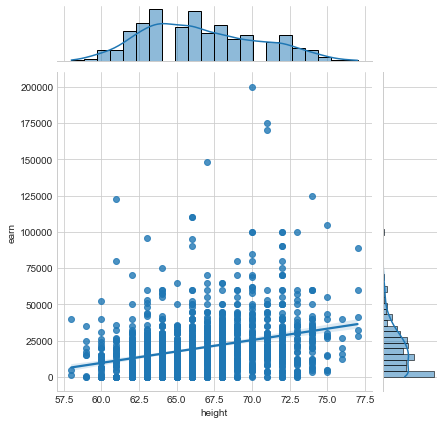

In [10]:
sns.jointplot(df['height'], df['earn'], kind='reg')

>El diagrama ejecutado entrega la siguiente información:
>
>>1. El diagrama nos informa de una asociación positiva entre ambas variables. Una salvedad a rescatar es que la asociación entre ambas es relativamente débil (su r de Pearson es de .30).
>>
>>2. La baja correlación puede ser explicada por la distribución de las variables. Mientras que height presenta una distribución relativamente normal, earn está fuertemente sesgada hacia valores bajos.
>>
>>3. Otro motivo que pueda estar influyendo levemente es que, si nos fijamos en los valores que toma la variable height de la tabla entregada por el método describe, los valores al parecer fueron redondeados (min, max y los cuartiles son números enteros), esta es la razón también de que se vean 'franjas' en el gráfico de dispersión.
>
>Para examinar la normalidad de nuestras variables, statsmodels presenta un gráfico de normalidad Q-Q (Quantile - Quantile).


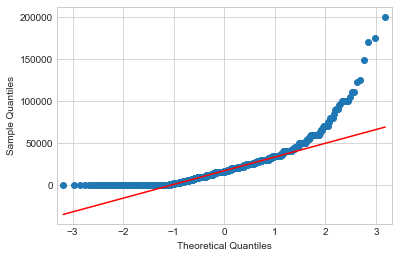

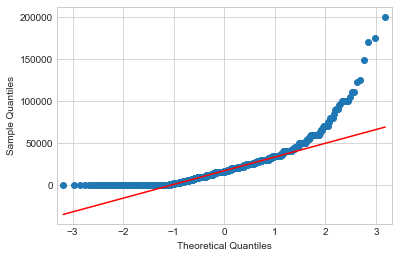

In [11]:
sm.qqplot(df['earn'],line='q')

>En el gráfico podemos observar que la variable escapa de los valores esperados en los extremos de la distribución. Éste es un punto a considerar en la modelación que veremos más adelante.
>
>El gráfico Q-Q compara la distribución empírica de nuestra variable en el eje Y (con la etiqueta 'Sample Quantities') contra la distribución esperada de la variable (bajo la etiqueta 'Theoretical Quantities').
>
>La opción line='q' permite trazar una línea entre cantidades observadas y esperadas en los cuantiles de nuestra variable. Una distribución normal tendrá la mayoría de sus datos cercanos a la línea.
>
>Si ejecutamos el mismo diagnóstico para heigth, el resultado es distinto.


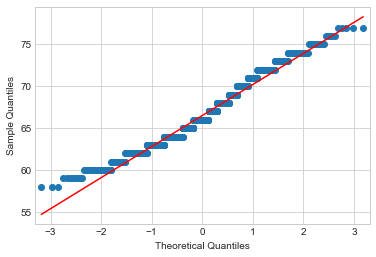

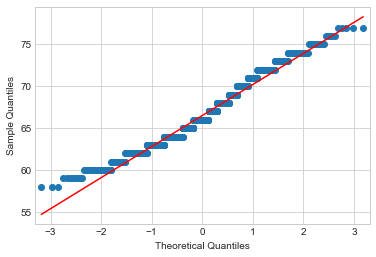

In [12]:
sm.qqplot(df['height'], line='q')

### Inspeccionando contribuciones en nuestra variable dependiente:
### Regresión Lineal
>
>Una vez realizadas las principales exploraciones, nuestro objetivo es generar una explicación plausible de cómo la altura de los individuos afecta los niveles de ingreso en promedio. Para ello, utilizaremos la regresión lineal, un método que permite extraer información sobre cómo una variable independiente contribuye en una variable dependiente. La regresión lineal es un método que resume cómo los valores de una variable objetivo de característica numérica varían en subpoblaciones definidas por una función lineal de atributos. Esta definición proviene de Gelman & Hill (2007) y pone énfasis en la característica descriptiva de la regresión por sobre la idea causal.
>
>Si bien la regresión puede utilizarse para representar asociaciones causales, preferimos enfatizar la capacidad de presentar comparaciones de promedios entre dos subpoblaciones. Así somos explícitos sobre las limitantes de la regresión al no considerar los supuestos de inferencia causal.
>
>Nuestra primera regresión
>
>Nuestro primer modelo a ejecutar tendrá la siguiente especificación
>
>![](fotos/reg_form.jpg)
>
>Donde buscamos generar un modelo que explique la varianza de earn en función a height.
>
>En la ecuación agregamos un ϵ para tomar en cuenta la incertidumbre de nuestro modelo.
>
>Volveremos a este punto cuando discutamos los supuestos que le dan validez al modelo (Teorema de Gauss-Markov).
>
>El objetivo del algoritmo es generar estimaciones respecto al intercepto (expresado como β 0 , que representa el punto de partida de la función lineal) y de la pendiente (expresada como β , que representa la contribución de en cuando cambia en 1 unidad). 
>
>Para implementar nuestra primera regresión, generamos un objeto a partir de smf.ols, el cual crea un modelo de regresión mediante el Método de Mínimos Cuadrados (Ordinary Least Squares). La función de statsmodels toma como mínimo dos parámetros:
>
>1. La declaración de la ecuación, que se realiza mediante sintáxis Patsy* con la siguiente forma canónica:
>
>2. Un objeto data, que en este caso responde a nuestro pd.DataFrame generado con pandas.
>
>>● La forma canónica permite separar entre nuestro fenómeno a estudiar y los atributos a agregar, separándolos por el operador ~, el cual define que el objetivo se puede explicar a partir de una función que contiene los atributos.
>>
>>● Mediante smf.ols() pasamos la función y una tabla de datos para generar un objeto con clase statsmodels.regression.linear_model.OLS.


In [13]:
# generamos un objeto que contenga nuestra ecuación descrita
model1 = smf.ols('earn ~ height', data = df)
# pidamos la extensión de la clase en nuestro objeto.
model1.__class__

statsmodels.regression.linear_model.OLS

>Hasta el momento sólo hemos generado un objeto con la clase detallada. Para generar las estimaciones de nuestro modelo, debemos ejecutar el método .fit(), que instruye al objeto para estimar los parámetros

In [14]:
model1 = model1.fit()

● Una vez que el modelo ya está estimado, podemos solicitar sus resultados mediante .summary()

In [15]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   earn   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     138.4
Date:                Thu, 08 Sep 2022   Prob (F-statistic):           1.65e-30
Time:                        16:52:44   Log-Likelihood:                -15475.
No. Observations:                1374   AIC:                         3.095e+04
Df Residuals:                    1372   BIC:                         3.097e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.487e+04   8926.986     -9.507      0.000   -1.02e+05   -6.74e+04
height      1574.4103    133.829     11.764      0.000    1311.879    1836.942
==============================================================================
Omnibus:                      868.584   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13733.247
Skew:                           2.677   Prob(JB):                         0.00
Kurtosis:                      17.533   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretación de un modelo de regresión
>
>statsmodel por defecto entrega variada información respecto a la ejecución, estadísticos de bondad de ajuste y los parámetros estimados.
>
>Estadísticos de Bondad de Ajuste: (R-squared, Adj. R-squared, F-statistic, Prob(F-statistic), No.Observations, etc...): Informan aspectos generales sobre nuestro modelo tales como su capacidad explicativa.

>1. R-squared y Adj R-squared: busca resumir en una cifra cuál es la capacidad explicativa de nuestros regresores (variables independientes) en la variabilidad de nuestro objetivo (variable dependiente). Para nuestro modelo ejecutado, la variabilidad de los ingresos en la muestra se explica en un 9.2% por la altura de los individuos en la
muestra. También se entrega un Adj. R-squared que entrega un estadístico similar al R-squared, pero penalizado por la cantidad de parámetros a estimar. Dado que no hay más parámetros a estimar, las diferencias entre ambos no son sustanciales.
>
>2. F-statistic y Prob(F-statistic): La prueba 𝐹surge de la distribución, que describe el rango de variabilidad entre partes explicadas y no explicadas. El valor de 𝐹 se contrasta con un puntaje de corte. En esta prueba se genera una hipótesis nula donde el modelo no es estadísticamente válido, y una hipótesis alternativa donde el modelo es estadísticamente válido. Estas reglas se simplifican en Prob(F-statistic), donde evaluaremos que sí 𝑃𝑟𝑜𝑏(𝐹 − 𝑠𝑡𝑎𝑡𝑖𝑠𝑡𝑖𝑐) ≤ 0. 05 , tenemos evidencia en contra de la hipótesis nula y hay más evidencia a favor de la significancia estadística general del modelo.
>
>3. Log-Likelihood (Log-Verosimilitud): Es el valor del logaritmo de la verosimilitud para el modelo ajustado. Un valor a veces reportado también por algunas librerías es LL-Null, el cual corresponde al valor de la log-verosimilitud del modelo sin variables independientes, este sirve para poder comparar el ajuste de nuestro modelo a los datos con respecto a un modelo sin predictores.
>
>4. AIC (Criterio de información de Akaike): Es una métrica de calidad relativa del ajuste de un modelo a los datos, esto significa que debe ser comparado siempre con respecto al valor AIC de otros modelos entrenados sobre los mismos datos y bajo las mismas condiciones. AIC Se define como:
>
>![](fotos/reg_form1.jpg)
>
Donde k es la cantidad de parámetros estimados por el modelo (En nuestro caso, estos serían la cantidad de coeficientes β ) y es el valor de la máxima verosimilitud 𝑖 𝐿 para el modelo. AIC sirve como métrica para selección de modelos, interesandonos siempre el modelo con menor AIC de entre los modelos candidatos (siempre y cuando, estemos comparando modelos ajustados bajo los mismos
datos/condiciones). Podemos ver que esta métrica penaliza a un modelo por la cantidad de parámetros que este implementa (k) por lo que esta métrica tiende a preferir modelos más parsimoniosos. Hay que notar que AIC no nos entrega una métrica con interpretación directa para evaluar la bondad de ajuste del modelo a los datos, por lo que perfectamente podríamos seleccionar, de entre una batería de modelos, aquél con menor AIC y esto no sería garantía alguna de que ese modelo en efecto tenga una buena performance. Una buena idea es entonces complementar
esta selección mediante AIC con una métrica de error absoluto.
>
>Finalmente, aunque en este sumario de regresión no aparece, a veces es reportado en algunas librerías un valor mostrado como “AICc”, el cual hace referencia a una versión de AIC corregido para los casos de tamaños muestrales pequeños.
>
>5. BIC (Criterio de Información Bayesiano): Funciona de forma similar a AIC en el sentido de ser una métrica de ajuste relativo que debe ser comparada de entre los valores obtenidos para un conjunto de modelos candidatos, prefiriendo siempre aquél con menor valor de BIC. Cómo se mencionó anteriormente, AIC intenta penalizar la sobre parametrización de modelos, lo cual puede resultar en un sobreajuste. La diferencia entre BIC y AIC es que BIC penaliza de mayor manera la sobre parametrización. 
>
>La fórmula de BIC es la siguiente:
>
>![](fotos/reg_form2.jpg)
>
>Donde k es la cantidad de parámetros estimados por el modelo, n es la cantidad de elementos en la muestra (número de observaciones) y 𝐿 es la verosimilitud máxima del modelo.
>
>Parámetros Estimados: La parte substancial del modelo se encuentra en su estimación paramétrica. Se estiman 𝑝 + 1 parámetros, donde 𝑝 es la cantidad de atributos a incluir en la fórmula. El 𝑝 + 1 surge de la estimación del intercepto (β 0), el punto de partida de nuestra recta. Por cada atributo agregado, se genera un β .
>
>Los parámetros se reportan con una serie de estadísticos asociados:
>
>>● coef: El parámetro estimado en sí.
>>
>>● std err: El error estándar asociado al parámetro.
>>
>>● t: El valor crítico del coeficiente.
>>
>>● P>|t|: El valor p que pone a prueba la significancia estadística del coeficiente.
>>
>>● [0.025 0.975]: El intervalo de confianza al 95% del parámetro.
>
>El intercepto informa sobre el punto de partida de nuestra recta. En nuestro primer modelo, nos sugiere que un individuo en la muestra con 0 pulgadas de altura tendrá en promedio un salario de 8847 dólares. La estimación de este coeficiente es significativa al 95% (nuestro valor p es menor a 0.05).
>
>El problema de esta interpretación del intercepto es que no tiene mucho sentido. No existen personas con 0 pulgadas. Para esto, hay que considerar el hecho que nuestro intercepto tiene sentido sólo en el contexto de nuestro modelo. Para tener una visión general, debemos considerar la pendiente de nuestra variable independiente.
>
>El coeficiente de height informa en cuánto cambia nuestro 𝑌 cuando 𝑥 aumenta en 1 unidad.
>
>Con un valor estimado de 1574 estadísticamente significativo al 95%, esperamos que la diferencia entre dos individuos de similares características que difieren sólo en una pulgada, sea de $1574 dólares. Podemos tentarnos a interpretar este coeficiente desde la causalidad: en la medida que un individuo crezca una pulgada, esperamos un incremento en su salario de 1574 dólares. Esta interpretación presenta una serie de problemas asociados a la causalidad:
>
>● La interpretación es menos flexible, puesto que forzamos un determinado flujo causal. ℎ𝑒𝑖𝑔ℎ𝑡 → 𝑒𝑎𝑟𝑛 implica que de forma irrestricta el salario subirá en la medida que la altura aumenta. Esto obliga al investigador a generar contrafactuales sin observaciones empíricas (¿Qué pasa con un individuo que por X motivo disminuye su altura?).
>
>● La interpretación causal también asume diseños estadísticos sofisticados, como series de panel, donde se realizan seguimientos a una muestra de individuos de forma temporal.
>
>● La interpretación causal impone una serie de supuestos difíciles de comprobar fuera de la estadística, asociados al diseño.
>
>Validez de las estimaciones
>
>Para entender la validez de nuestras estimaciones mediante Mínimos Cuadrados Ordinarios, es necesario estudiar someramente cómo se generan.
>
>La obtención paramétrica de los β descansa en el método de mínimos cuadrados (MCO).
>
>El objetivo del MCO es encontrar un estimador que reduzca la distancia residual entre los valores predichos y sus correlatos observados.
>
>Bajo este enfoque, se asume que los parámetros verdaderos (o poblacionales) son desconocidos y buscamos generar aproximaciones.
>
>Si tenemos un modelo con la siguiente forma:
>
>![](fotos/reg_form3.jpg)
>
>Buscamos un estimador que minimice la suma de errores cuadráticos:
>
>![](fotos/reg_form4.jpg)
>
>Observación: MCO es un método intuitivo y fácil de entender y programar, sin embargo, está lejos de ser perfecto. Una de las más grandes debilidades de MCO es que es extremadamente sensible a valores extremos (outliers), ya sea porque los puntos (𝑥𝑖 , 𝑦𝑖) son muy pequeños o demasiado grandes en comparación con el resto de la muestra. En estos casos, el cuadrado de la distancia es una cantidad que puede llevar a desequilibrar por completo la recta de la regresión, los casos en que estos outliers son producto del error humano o de instrumentación pueden ser fatales para el modelo.
>
>En la figura generada con gfx.gauss_markov() se presentan tres posibles estimadores candidatos para encontrar nuestro parámetro verdadero (β). Éstos difieren en sus componentes paramétricos, asumiendo que se comportan de forma asintóticamente normal β .
>
>● Nuestra primera estimación β tiene una media similar a nuestro parámetro 1 verdadero, pero su varianza es grande.
>
>● Nuestra segunda estimación β tiene una media superior al parámetro verdadero y 2 una varianza similar a la primera estimación.
>
>● Nuestra tercera y última estimación β tiene una media idéntica a la primera 3 estimación, pero una menor varianza.
>
>● En este caso, la estimación β falla en capturar el parámetro poblacional, por lo que 2 es descartada.
>
>● Entre la estimación β y , ésta última satisface las condiciones de Gauss-Markov, 1 β 3 dado que su varianza es menor y asegura que error tendrá una media menor.
>
>● El cumplimiento de las condiciones de Gauss Markov nos asegurará que el estimador será el estimador lineal insesgado y óptimo, obteniendo el estimador eficiente dentro de la clase de estimadores lineales insesgados.

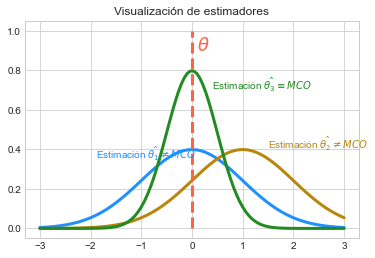

In [16]:
gfx.gauss_markov()

### ¿Cuáles son las condiciones de Gauss-Markov?
#### El teorema de Gauss-Markov descansa en cinco supuestos:
>
>1. La media del error es 0 (𝐸[ε ): No hay sesgo sistemático de forma positiva o 𝑖 ] = 0 negativa respecto a los errores muestrales. Su media será 0 para estos casos. Surge de este supuesto que cuando 𝑋 es igual a su media, 𝑌 también lo será.
>
>2. Independencia del error y las variables explicativas (𝐸[ε ): Los residuos no 𝑖 |𝑋 𝑖 ] = 0 están determinados por la variable explicativa.
>
>3. Ausencia de correlación entre los residuos (𝐸[ε ): Los residuos de las 𝑖 |ε 𝑗 ] = 0(𝑖 ≠ 𝑗) observaciones distintas deben ser estadísticamente independientes. La información del residuo para un caso no debe afectar el signo o valor de los residuos para otros casos. Ante los casos de correlación existente entre los residuos, hablamos de correlación serial o correlación espacial.
>
>4. Ausencia de correlación entre la varianza y las variables (𝐸[ε ): La 𝑖 2 ] = 𝑐𝑜𝑛𝑠𝑡𝑎𝑛𝑡𝑒 varianza de los errores en cualquier valor de 𝑋 debe ser independiente a 𝑋 e 𝑌.
>
>5. Distribución normal de los errores (ϵ ): Se asume que los errores deben 𝑖 ∼ 𝑁(0, σ 2 tener una distribución empírica cercana a la normal para todo el rango de 𝑋 . ¿Qué supuestos son los más relevantes?
>
>Gelman y Hill (2007) sugieren que los supuestos se pueden ordenar de más importantes a menos importantes.
>
>● Validez: Los datos que analizamos deben estar relacionados con la pregunta de investigación que se busca responder. Suena obvio, pero muchas veces se ignora.
>
>● Aditividad y Linealidad: El supuesto más importante desde la matemática es que el componente determinístico (la ecuación) es una función lineal de los predictores.
>
>● Independencia de los errores: Los errores deben estar libres de correlaciones entre sí mismos y no deben afectar a las demás mediciones.
>
>●Normalidad de los errores: Generalmente no es problemático el tener distribuciones no-normales, puesto que se pueden aplicar transformaciones como 𝑙𝑜𝑔(𝑥), 𝑥, .
>
### Diagnósticos de nuestro modelo
>
>Para comprobar los supuestos Gauss-Markov mencionados anteriormente, la inspección más intuitiva es mediante gráficos.
>
>statsmodels presenta plot_regress_exog, que entrega cuatro gráficos respecto a nuestro modelo de regresión:
>
>1. Y and Fitted vs. X: Grafica los valores predichos (𝑦) y valores empíricos a lo largo de X. Sirve para visualizar en qué valores de X se genera una mejor predicción de los valores empíricos. Observamos que hay valores que se escapan sustancialmente de lo predicho cuando la altura es cercana a las 70 pulgadas.
>
>2. Residuals versus X: Permite visualizar la heterocedasticidad del modelo al graficar el error residual (ε ) a lo largo de nuestra variable exógena si encontramos una 𝑖 tendencia lineal en la nube de datos. En base al gráfico observamos un patrón de embudo, donde en la medida que aumenta la altura los errores tienden a variar más. Podemos decir que el predictor es heterocedástico en el modelo y necesitamos corregirlo.
>
>3. Partial regression plot: Grafica la evolución de la expectativa de la variable dependiente condicional a los valores de la variable independiente estandarizada.
>
>4. CCPR Plot (Component and Component Plus Residual): Generan un gráfico entre el componente (X) y los residuales de predicción. Permiten diagnosticar especificaciones a la variable.

eval_env: 1


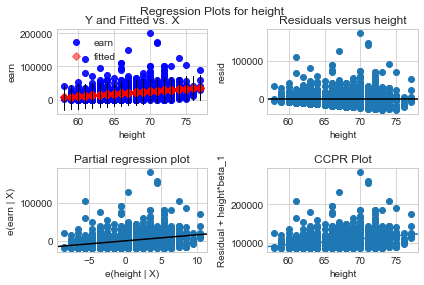

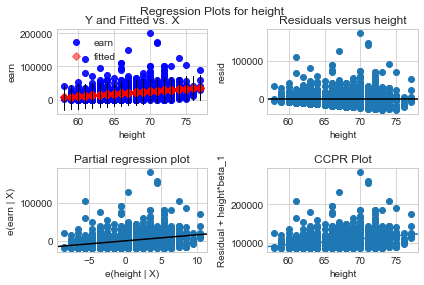

In [17]:
sm.graphics.plot_regress_exog(model1, 'height')